# Predictions for IFN T cell responses in healthy individuals infected with Mtb in a South African cohort. 

The authors used eleven representative Mtb antigens and a large panel of previously defined Mtb epitopes. 50– 75% of the total response in a cohort of 63 individuals. As expected, responses were highly heterogeneous, with responses to a total of 125 epitopes detected

Reference:

Lindestam Arlehamn, C.S. et al., 2016. A Quantitative Analysis of Complexity of Human Pathogen-Specific CD4 T Cell Responses in Healthy M. tuberculosis Infected South Africans. PLOS Pathogens, 12(7), p.e1005760. Available at: http://dx.plos.org/10.1371/journal.ppat.1005760.

In [19]:
import os, math
import numpy as np
import pandas as pd
pd.set_option('display.width', 120)
pd.set_option('max_colwidth', 90)
%matplotlib inline
import matplotlib.pyplot as plt
import epitopepredict as ep
from epitopepredict import sequtils, analysis, base, tepitope, plotting, utilities
from IPython.display import display, HTML
import seaborn as sns
from importlib import reload
sns.set_style("ticks", {'axes.facecolor': '#F7F7F7', 'axes.grid': False,
                        'legend.frameon':True, 'legend.fontsize':12})
sns.set_context("notebook", font_scale=1.4)

## get exp dataset

In [ ]:
#sette mtb epitopes
sette = pd.read_csv('sette_SA_MTB_epitopes.csv')
proteins = sorted(sette.name.unique())
mtb = sequtils.genbank_to_dataframe(base.mtb_genome,cds=True)
mtb = mtb[mtb.locus_tag.isin(sette.name)]

df = pd.merge(sette, mtb[['locus_tag','translation']],left_on='name',right_on='locus_tag')
df['start'] = df.apply( lambda x: x.translation.find(x.sequence), 1 )
df['end'] = df.start+df.sequence.str.len()
#for i,r in df[df.start==-1].iterrows():
#    print (r.locus_tag, r.sequence, r.translation)
df=df.drop('translation',1)
df=df[df.start>=0]
prots = df.name.unique()
exp = df
print (df)

In [3]:
donoralleles = pd.read_csv('sa_mtb_donor_alleles.csv')
donoralleles = donoralleles.set_index('Donor ID')
donoralleles = donoralleles.apply(lambda x: 'HLA-'+x)
#print donoralleles

x = donoralleles.apply(lambda x : x.value_counts())
x = x.sum(1).sort_values(ascending=False)
x = x[x>=2]
drballeles = x[x.index.str.contains('DRB')]
drballeles = list(drballeles.index)
#print drballeles
dqalleles = x[x.index.str.contains('DQ')]
dqalleles = list(dqalleles.index)


## run predictions

In [4]:
Pt=ep.get_predictor('tepitope')
Pt.predict_sequences(mtb, alleles=drballeles,path='mtbsa_tepitope', overwrite=False, threads=10)
Pt.load(path='mtbsa_tepitope')
Pn=ep.get_predictor('netmhciipan')
Pn.predict_sequences(mtb, alleles=drballeles,path='mtbsa_netmhciipan', overwrite=False, threads=10)
Pn.load(path='mtbsa_netmhciipan')

predictions done for 29 sequences in 27 alleles
results saved to /home/damien/gitprojects/epitopepredict/examples/mtbsa_tepitope
predictions done for 29 sequences in 27 alleles
results saved to /home/damien/gitprojects/epitopepredict/examples/mtbsa_netmhciipan


['Rv0124', 'Rv0125', 'Rv0129c', 'Rv0256c', 'Rv0280', 'Rv0288', 'Rv1047', 'Rv1172c', 'Rv1195', 'Rv1196', 'Rv1705c', 'Rv1886c', 'Rv1908c', 'Rv1926c', 'Rv2031c', 'Rv2608', 'Rv2770c', 'Rv3024c', 'Rv3025c', 'Rv3136', 'Rv3330', 'Rv3615c', 'Rv3619c', 'Rv3620c', 'Rv3804c', 'Rv3873', 'Rv3874', 'Rv3875', 'Rv3876']


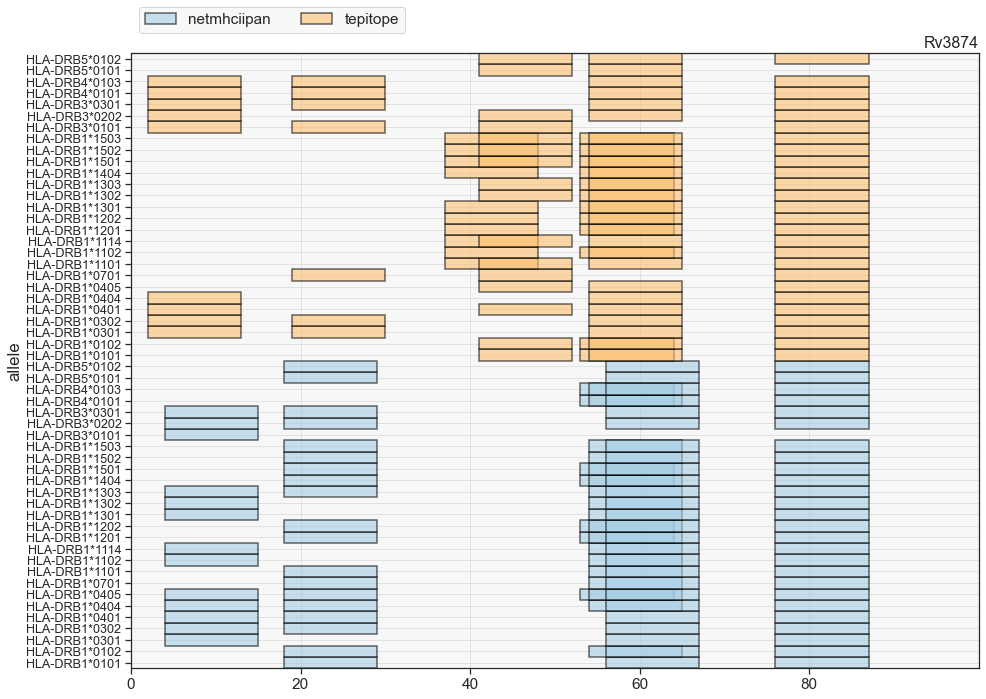

In [14]:
print (proteins)
ax = plotting.plot_tracks([Pn,Pt],name=proteins[-3],
                     n=5, cutoff=10, kind='tracks',                   
                     legend=True, cutoff_method='rank',            
                     figsize=(14,10))


## overlap of top ranking binders

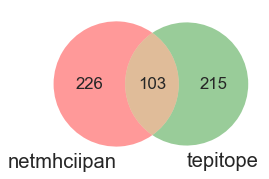

In [13]:
bn = Pn.get_binders(cutoff=5,cutoff_method='rank',limit=20)#, name='Rv3875')
bt = Pt.get_binders(cutoff=5,cutoff_method='rank',limit=20)#, name='Rv3875')
ax = utilities.venndiagram([bn.peptide,bt.peptide], ['netmhciipan','tepitope'])

## overlap of promiscuous binders

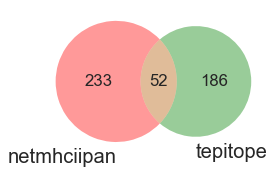

In [15]:
pbn = Pn.promiscuous_binders(n=5, cutoff=10, cutoff_method='rank')
pbt = Pt.promiscuous_binders(n=5, cutoff=10, cutoff_method='rank')
ax = utilities.venndiagram([pbn.peptide,pbt.peptide], ['netmhciipan','tepitope'])

In [ ]:
#compare to exp results?
reload(analysis)
P=Pt
labels=['netmhciipan','tepitope']
res=[]
for P in [Pn, Pt]:
    #binders by median rank    
    rb = P.promiscuous_binders(cutoff_method='rank',cutoff=30,n=5)
    #all binders by promiscuity, just use low perc to get all
    pball = P.promiscuous_binders(n=1, cutoff=0.4).sort_values(['alleles','median_rank'],ascending=False)
    #reload(analysis)
    a = analysis.prediction_coverage(exp, pball, key='sequence', perc=50)
    print (a)
    b = analysis.prediction_coverage(exp, rb, key='sequence', perc=50)
    res.append({'all':a,'ranked':b})
    
x = pd.DataFrame(res,index=['netmhciipan','tepitope'])
print (x)
x.plot(kind='barh')


29
    cutoff  len1  len2  lenb  netMHCIIpan  tepitope      both
0        2    67    53   118     0.233333  0.166667  0.316667
1        5   160   131   265     0.483333  0.433333  0.600000
2        8   228   189   381     0.533333  0.533333  0.700000
3       11   309   250   505     0.633333  0.650000  0.766667
4       14   375   314   623     0.700000  0.700000  0.783333
5       17   444   380   745     0.700000  0.716667  0.800000
6       20   510   442   855     0.716667  0.733333  0.833333
7       23   589   497   970     0.766667  0.733333  0.850000
8       26   662   569  1095     0.800000  0.750000  0.850000
9       29   737   630  1207     0.866667  0.833333  0.900000
10      32   795   678  1303     0.833333  0.833333  0.900000
11      35   856   722  1389     0.850000  0.833333  0.900000
12      38   921   778  1497     0.866667  0.833333  0.900000


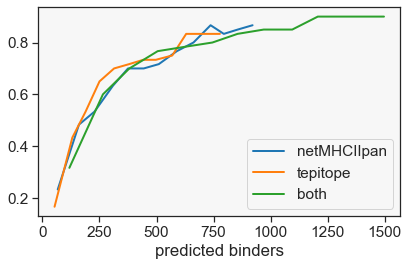

In [207]:
import difflib

def get_hits(n):
    cutoffs = range(2,40,3)
    res = []
    for c in cutoffs:
        rbn = Pn.promiscuous_binders(cutoff_method='rank',cutoff=c,n=n)
        rbt = Pt.promiscuous_binders(cutoff_method='rank',cutoff=c,n=n)
        rboth = pd.concat([rbn,rbt]).drop_duplicates(['peptide','name'])
        #print (rbt[:15])
        #print (len(rbn),len(rbt),len(rboth))
        df=exp#[exp.name==name].copy()
        def find_matches(x, p):
            return len(difflib.get_close_matches(x.sequence, p, n=10, cutoff=.6))

        df.loc[:,'hits1'] = df.apply(lambda x: find_matches(x, rbn.peptide),1)        
        f1 = len(df[df.hits1>0])/len(df)
        df.loc[:,'hits2'] = df.apply(lambda x: find_matches(x, rbt.peptide),1)
        f2 = len(df[df.hits2>0])/len(df)
        #print (df[:10])
        b = (len(df[(df.hits1>0) | (df.hits2>0)]))/len(df)
        res.append({'cutoff':c,'len1':len(rbn),'len2':len(rbt),'lenb':len(rboth),
                    'netMHCIIpan':f1, 'tepitope':f2, 'both':b})
    res = pd.DataFrame(res)
    return res

print (len(proteins))
n=5
res = get_hits(n)
print (res)
ax=res.plot(x='len1',y='netMHCIIpan',lw=2)
res.plot(x='len2',y='tepitope',lw=2,ax=ax)
res.plot(x='lenb',y='both',lw=2,ax=ax)
plt.xlabel('predicted binders')
plt.tight_layout()
plt.savefig('mtb_sette_hits.png',dpi=150)

IndexError: index 9 is out of bounds for axis 0 with size 9

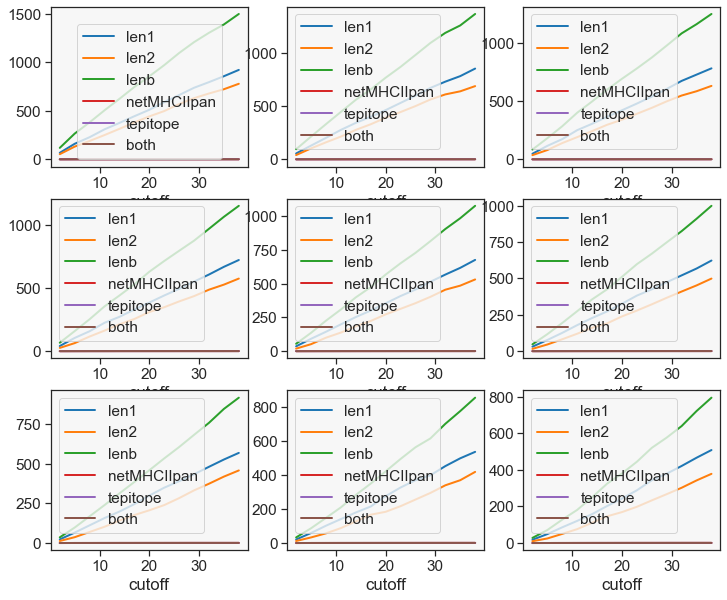

In [205]:
fig,axs=plt.subplots(3,3,figsize=(12,10))
axs=axs.flat
i=0
for n in range(5,15):
    res = get_hits(n)    
    res.plot(x='len1',y='netMHCIIpan',lw=2,ax=axs[i])
    res.plot(x='len2',y='tepitope',lw=2,ax=axs[i])
    i+=1

In [190]:
r=Pn.promiscuous_binders(cutoff_method='rank',cutoff=10,n=7,name='Rv3875')
r

,peptide,pos,name,alleles,core,score,mean,median_rank
12,LNNALQNLART,65,Rv3875,25,LNNALQNLA,197.54,2182.812800,5.0
6,GNVTSIHSLLD,20,Rv3875,20,VTSIHSLLD,420.21,2448.403000,3.5
15,NALQNLARTIS,67,Rv3875,19,ALQNLARTI,196.24,2079.516842,5.0
17,NNALQNLARTI,66,Rv3875,18,NNALQNLAR,519.66,2465.490556,6.5
30,WNFAGIEAAAS,6,Rv3875,13,WNFAGIEAA,60.82,1608.739231,2.0
9,IQGNVTSIHSL,18,Rv3875,11,IQGNVTSIH,690.27,3304.701818,5.0
16,NFAGIEAAASA,7,Rv3875,10,FAGIEAAAS,48.83,1504.297000,2.5
10,KQSLTKLAAAW,33,Rv3875,10,KQSLTKLAA,263.44,1584.218000,5.0
23,QSLTKLAAAWG,34,Rv3875,10,LTKLAAAWG,114.99,2291.129000,5.5
